In [57]:
####### Food 101 dataset CNN ######

In [183]:
# pytorch imports
import torch
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader
from torch import nn
import torch.nn as nn
import torch.nn.functional as F
import tarfile

# other required imports
import os
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from shutil import copy
import requests

In [199]:
batch_size = 32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# we're using imagenet stats to normalize the 3 channels of the data RGB,
# but it doesn't seem to make a difference even if we normalized based
# on the distribution of dataset
imagenet_stats = {'mean': (0.485, 0.456, 0.406), 'std_dev': (0.229, 0.224, 0.225)}

FOOD_DATA_BASE_PATH = "./food-101"
IMAGES_PATH = FOOD_DATA_BASE_PATH + "/images"
META_PATH = FOOD_DATA_BASE_PATH + "/meta"
TRAIN_PATH = FOOD_DATA_BASE_PATH + "/train"
VALID_PATH = FOOD_DATA_BASE_PATH + "/valid"
MODEL_PATH = 'model_data/'

print('Food path : ' + str(FOOD_DATA_BASE_PATH))
print('Images path : ' + str(IMAGES_PATH))
print('Meta directory path: ' + str(META_PATH))

Food path : ./food-101
Images path : ./food-101/images
Meta directory path: ./food-101/meta


In [200]:
class DataPreload():
    def __init__(self):
        self.training_dataset, self.testing_dataset, self.train_cls, self.valid_cls = [None]*4
        self.imgenet_mean = imagenet_stats['mean']
        self.imgenet_std = imagenet_stats['std_dev']
   
    def download_and_untar_data(self):
        if "food-101" in os.listdir():
            print("Dataset already exists")
        else:
            print("Downloading the data...")
            print('Beginning file download with requests')
            url = 'http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz'
            r = requests.get(url)

            with open('./food-101.tar.gz', 'wb') as f:
                f.write(r.content)

            print("Dataset downloaded!")
            print("Extracting data..")
            file_to_untar = tarfile.open('./food-101.tar.gz')
            file_to_untar.extractall('./food-101')
            print("Extraction done!")
        
    def _get_transforms(self):
        training_data_transformations = transforms.Compose([
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(), 
            transforms.ToTensor(),
            transforms.Normalize(self.imgenet_mean, self.imgenet_std)])
        
        test_data_transformations = transforms.Compose([
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(self.imgenet_mean, self.imgenet_std)])        
        return training_data_transformations, test_data_transformations            
            
    def get_dataset(self, root_dir='./food-101/'):
        training_data_transformations, test_data_transformations = self._get_transforms() # transformations
        self.training_dataset = datasets.ImageFolder(root=TRAIN_PATH, transform=training_data_transformations)
        self.testing_dataset = datasets.ImageFolder(root=VALID_PATH, transform=test_data_transformations)        
        self.train_classes = self.training_dataset.classes
        self.test_classes = self.testing_dataset.classes

        assert self.train_classes == self.test_classes
        return self.training_dataset, self.testing_dataset, self.train_classes

    
    def get_dataloaders(self, training_dataset, testing_dataset, batch_size, **kwargs):
        return (DataLoader(training_dataset, batch_size=batch_size, shuffle=True, **kwargs),
               DataLoader(testing_dataset, batch_size=batch_size//2, shuffle=False, **kwargs))

    # Helper method to split dataset into train and test folders
    def prepare_data(self, filepath, src, dest):
        if dest.split('/')[-1] in os.listdir(FOOD_DATA_BASE_PATH):
            print("Data preparation not needed. Data already exists")
            return
        
        classes_images = defaultdict(list)
        with open(filepath, 'r') as txt:
            paths = [read.strip() for read in txt.readlines()]
            for p in paths:
                food = p.split('/')
                classes_images[food[0]].append(food[1] + '.jpg')

        for food in classes_images.keys():
            print("\nCopying images into ", food)
            if not os.path.exists(os.path.join(dest,food)):
                os.makedirs(os.path.join(dest,food))
            for i in classes_images[food]:
                copy(os.path.join(src,food,i), os.path.join(dest,food,i))
        print("Copying Done!")
    

In [201]:
data_preload = DataPreload()
data_preload.download_and_untar_data()

print("Creating training and testing data using the train.txt & test.txt files....")
data_preload.prepare_data(META_PATH + '/train.txt', IMAGES_PATH, TRAIN_PATH)
data_preload.prepare_data(META_PATH + '/test.txt', IMAGES_PATH, VALID_PATH)

training_dataset, testing_dataset, classes =  data_preload.get_dataset()
num_classes = len(classes)
print('Classes: ' + str(classes))
print('Num classes: ' + str(num_classes))

train_dl, valid_dl = data_preload.get_dataloaders(training_dataset, testing_dataset, batch_size=batch_size, num_workers=2)


Dataset already exists
Creating training and testing data using the train.txt & test.txt files....
Data preparation not needed. Data already exists
Data preparation not needed. Data already exists
Classes: ['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito', 'bruschetta', 'caesar_salad', 'cannoli', 'caprese_salad', 'carrot_cake', 'ceviche', 'cheese_plate', 'cheesecake', 'chicken_curry', 'chicken_quesadilla', 'chicken_wings', 'chocolate_cake', 'chocolate_mousse', 'churros', 'clam_chowder', 'club_sandwich', 'crab_cakes', 'creme_brulee', 'croque_madame', 'cup_cakes', 'deviled_eggs', 'donuts', 'dumplings', 'edamame', 'eggs_benedict', 'escargots', 'falafel', 'filet_mignon', 'fish_and_chips', 'foie_gras', 'french_fries', 'french_onion_soup', 'french_toast', 'fried_calamari', 'fried_rice', 'frozen_yogurt', 'garlic_bread', 'gnocchi', 'greek_salad', 'grilled_cheese_sandwich', 'grilled_salmon', 'g

In [202]:
class DataModel():
    def __init__(self, train_dl, valid_dl, c=None):
        self.train_dl, self.valid_dl, self.c = train_dl, valid_dl, c
    
    @property
    def training_dataset(self): return self.train_dl.dataset
    
    @property
    def testing_dataset(self): return self.valid_dl.dataset
    
    def __repr__(self):
        return str(self.__class__.__name__)+" obj (train & valid DataLoaders)"


In [203]:
data = DataModel(train_dl, valid_dl, c=num_classes)

print('DataModel valid dataset: ')
print(data.testing_dataset)

print('Data classes: ')
print(data.c)

print('Data training dataset: ')
print(data.training_dataset)


DataModel valid dataset: 
Dataset ImageFolder
    Number of datapoints: 25250
    Root location: ./food-101/valid
    StandardTransform
Transform: Compose(
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
           )
Data classes: 
101
Data training dataset: 
Dataset ImageFolder
    Number of datapoints: 75750
    Root location: ./food-101/train
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
           )


In [204]:
# This can be used to print predictions too
def show_ds(trainset, classes, validset=None, cols=6, rows=17, preds=None, is_pred=False, is_valid=False):        
    fig = plt.figure(figsize=(25,25))
    fig.suptitle(f"Showing one random image from each {'Validation' if is_valid else 'Train'} classes", y=0.92, fontsize=24) # Adding  y=1.05, fontsize=24 helped me fix the suptitle overlapping with axes issue
    columns = cols
    rows = rows
    imgenet_mean = imagenet_stats['mean']
    imgenet_std = imagenet_stats['std_dev']

    for i in range(1, columns*rows +1):
        fig.add_subplot(rows, columns, i)
        
        if is_pred and testset:
            img_xy = np.random.randint(len(testset));
            np_img = testset[img_xy][0].numpy()
            img = np.transpose(np_img, (1,2,0))            
            img = img * imgenet_std + imgenet_mean
        else:
            img_xy = np.random.randint(len(trainset));
            np_img = trainset[img_xy][0].numpy()
            img = np.transpose(np_img, (1,2,0))
            img = img * imgenet_std + imgenet_mean
        
        if is_pred:
            plt.title(classes[int(preds[img_xy])] + "/" + classes[testset[img_xy][1]])
        else:
            plt.title(classes[trainset[img_xy][1]])
        plt.axis('off')
        img = np.clip(img, 0, 1)
        plt.imshow(img, interpolation='nearest')
    plt.show()


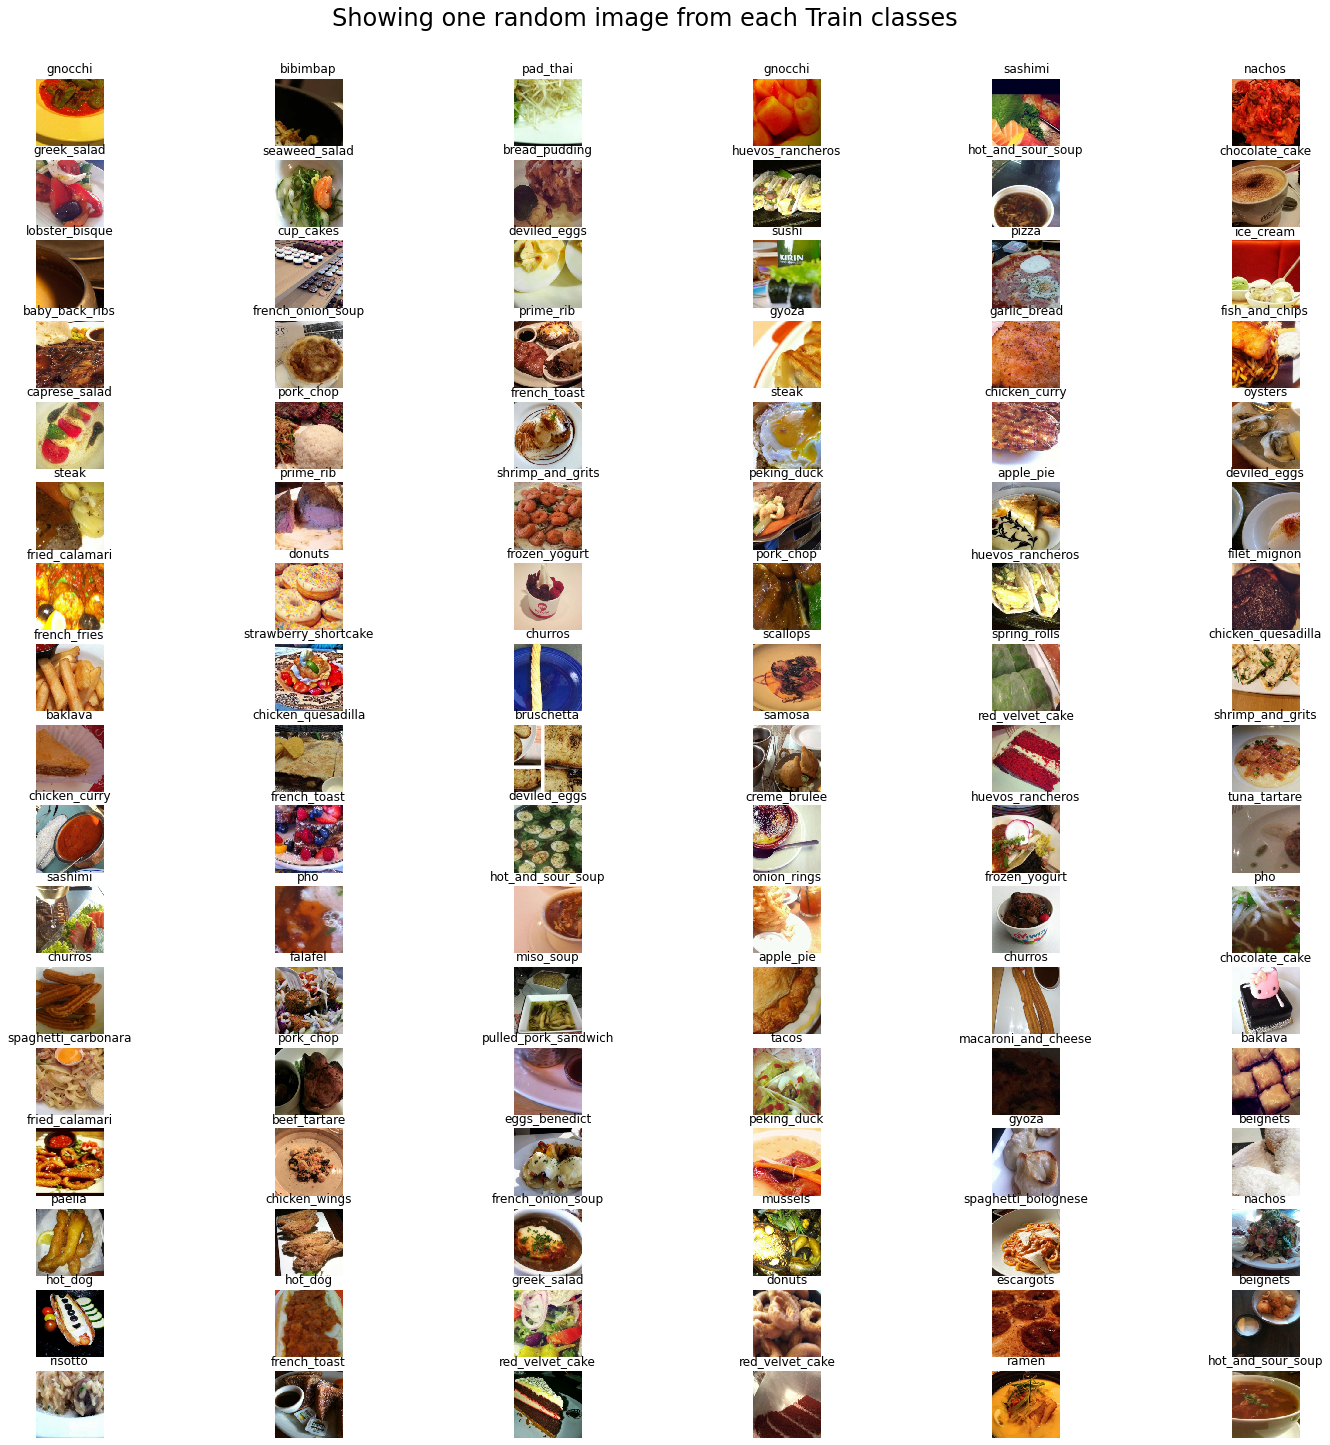

In [205]:
show_ds(data.training_dataset, classes)

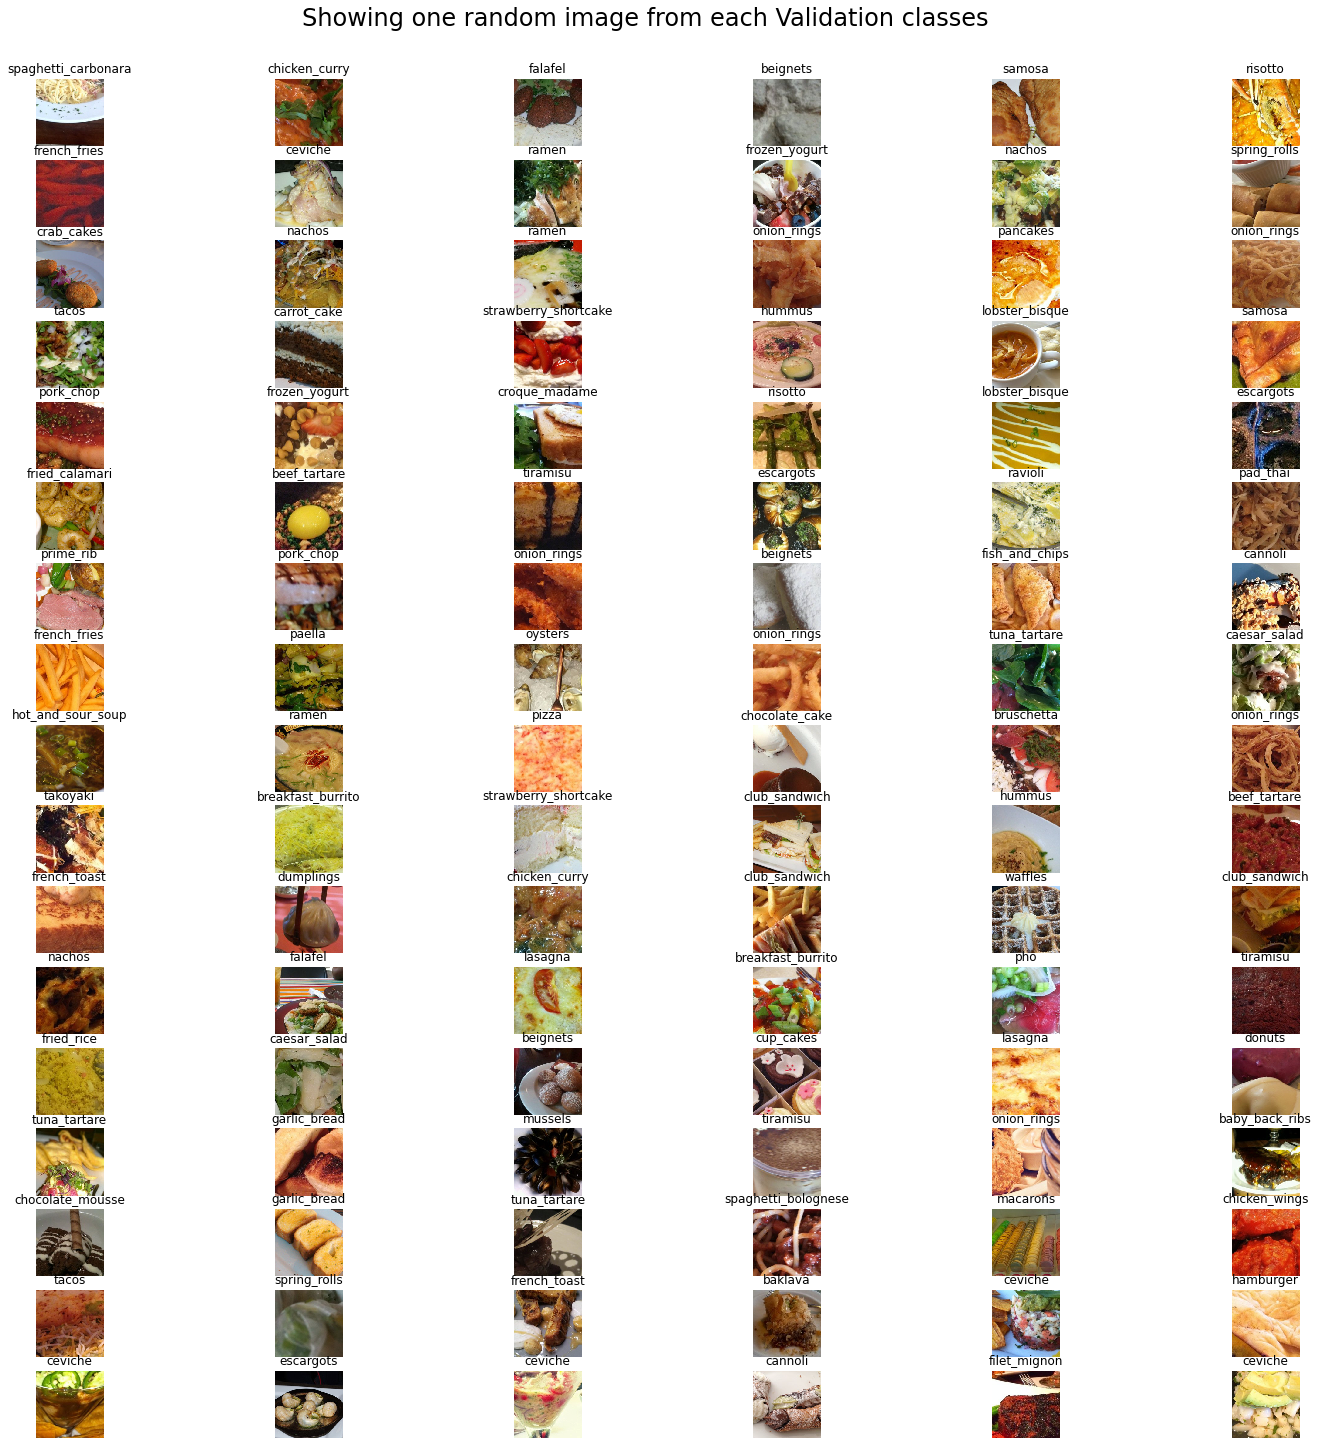

In [206]:
show_ds(data.testing_dataset, classes, is_valid=True)

In [207]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [213]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    print('Model evaluated')
    print('Now getting to outputs...')
    outputs = []
    batch_ctr = 0
    for batch in val_loader:
        outputs.append(model.validation_step(batch))
        batch_ctr += 1
        # TODO: if needed pause evaluation since it's slow?
        if batch_ctr % 50 == 0:
            print('Evaluation current batch ctr: ' + str(batch_ctr))
    return model.validation_epoch_end(outputs)

# Move tensors to a particular device
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

def fit(epochs, learning_rate, model, train_loader, val_loader, opt_func=torch.optim.SGD, regularization=False):
    history = []
    if (regularization):
        optimizer = opt_func(model.parameters(), learning_rate, weight_decay=1e-5)
    else:
        optimizer = opt_func(model.parameters(), learning_rate)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        batch_ctr = 0
        print('Training current epoch: ' + str(epoch))
        for batch in train_loader:
            batch_ctr += 1
            if batch_ctr % 50 == 0:
                print('Training current batch ctr: ' + str(batch_ctr))
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [229]:
class SimpleCNN_1(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(8, 8), # output: 16 x 28 x 28
            nn.MaxPool2d(4, 4), # output: 16 x 7 x 7   # simplify this later
            nn.Flatten(),
            nn.ReLU(),
            nn.Linear(16 * 7 * 7, 101))
        
    def forward(self, xb):
        return self.network(xb)
    
class SimpleCNNWithDropout(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(8, 8), # output: 16 x 28 x 28
            nn.MaxPool2d(4, 4), # output: 16 x 7 x 7   # simplify this later
            nn.Flatten(),
            nn.Dropout(0.7),
            nn.ReLU(),
            nn.Linear(16 * 7 * 7, 101))
        
    def forward(self, xb):
        return self.network(xb)
    
class AllConvCNN(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=3, stride=(8, 8), padding=(1, 1)),
            nn.Conv2d(16, 16, kernel_size=3, stride=(4, 4), padding=(1, 1)),
            nn.Flatten(),
            nn.ReLU(),
            nn.Linear(16 * 7 * 7, 101))
        
    def forward(self, xb):
        return self.network(xb)


## Simple Convolutional Network

In [216]:
model = to_device(SimpleCNN_1(), device)

for images, labels in valid_dl:
    print('images.shape:', images.shape)
    break


images.shape: torch.Size([16, 3, 224, 224])


In [217]:
num_epochs = 1
opt_func = torch.optim.Adam
learning_rate = 0.01

history = fit(num_epochs, learning_rate, model, train_dl, valid_dl, opt_func)
# evaluate model after training
print(history)

Training current epoch: 0
Training current batch ctr: 50
Training current batch ctr: 100
Training current batch ctr: 150
Training current batch ctr: 200
Training current batch ctr: 250
Training current batch ctr: 300
Training current batch ctr: 350
Training current batch ctr: 400
Training current batch ctr: 450
Training current batch ctr: 500
Training current batch ctr: 550
Training current batch ctr: 600
Training current batch ctr: 650
Training current batch ctr: 700
Training current batch ctr: 750
Training current batch ctr: 800
Training current batch ctr: 850
Training current batch ctr: 900
Training current batch ctr: 950
Training current batch ctr: 1000
Training current batch ctr: 1050
Training current batch ctr: 1100
Training current batch ctr: 1150
Training current batch ctr: 1200
Training current batch ctr: 1250
Training current batch ctr: 1300
Training current batch ctr: 1350
Training current batch ctr: 1400
Training current batch ctr: 1450
Training current batch ctr: 1500
Trai

## All Convolutional Neural Network

In [224]:
model = to_device(AllConvCNN(), device)

for images, labels in valid_dl:
    print('images.shape:', images.shape)
    break


num_epochs = 1
opt_func = torch.optim.Adam
learning_rate = 0.01

history = fit(num_epochs, learning_rate, model, train_dl, valid_dl, opt_func)
# evaluate model after training
print(history)

images.shape: torch.Size([16, 3, 224, 224])
Training current epoch: 0
Training current batch ctr: 50
Training current batch ctr: 100
Training current batch ctr: 150
Training current batch ctr: 200
Training current batch ctr: 250
Training current batch ctr: 300
Training current batch ctr: 350
Training current batch ctr: 400
Training current batch ctr: 450
Training current batch ctr: 500
Training current batch ctr: 550
Training current batch ctr: 600
Training current batch ctr: 650
Training current batch ctr: 700
Training current batch ctr: 750
Training current batch ctr: 800
Training current batch ctr: 850
Training current batch ctr: 900
Training current batch ctr: 950
Training current batch ctr: 1000
Training current batch ctr: 1050
Training current batch ctr: 1100
Training current batch ctr: 1150
Training current batch ctr: 1200
Training current batch ctr: 1250
Training current batch ctr: 1300
Training current batch ctr: 1350
Training current batch ctr: 1400
Training current batch ctr

## Regularization

In [242]:
model = to_device(SimpleCNNWithDropout(), device)

for images, labels in valid_dl:
    print('images.shape:', images.shape)
    break


num_epochs = 1
opt_func = torch.optim.Adam
learning_rate = 0.01

history = fit(num_epochs, learning_rate, model, train_dl, valid_dl, opt_func)
# evaluate model after training
print(history)

images.shape: torch.Size([16, 3, 224, 224])
Training current epoch: 0
Training current batch ctr: 50
Training current batch ctr: 100
Training current batch ctr: 150
Training current batch ctr: 200
Training current batch ctr: 250
Training current batch ctr: 300
Training current batch ctr: 350
Training current batch ctr: 400
Training current batch ctr: 450
Training current batch ctr: 500
Training current batch ctr: 550
Training current batch ctr: 600
Training current batch ctr: 650
Training current batch ctr: 700
Training current batch ctr: 750
Training current batch ctr: 800
Training current batch ctr: 850
Training current batch ctr: 900
Training current batch ctr: 950
Training current batch ctr: 1000
Training current batch ctr: 1050
Training current batch ctr: 1100
Training current batch ctr: 1150
Training current batch ctr: 1200
Training current batch ctr: 1250
Training current batch ctr: 1300
Training current batch ctr: 1350
Training current batch ctr: 1400
Training current batch ctr

## Transfer Learning

In [243]:
import pytorch_lightning as pl

class ImageClassifier(pl.LightningModule):
    def __init__(self, num_classes=101, lr=1e-3):
        super().__init__()
        self.save_hyperparameters()
        # self.num_classes = num_classes
        # self.lr = lr

        self.model = models.resnet50(pretrained=True)

        for param in self.model.parameters():
            param.requires_grad = False

        self.model.fc = torch.nn.Linear(self.model.fc.in_features, num_classes)

    def training_step(self, batch, batch_idx):
        # return the loss given a batch: this has a computational graph attached to it: optimization
        x, y = batch
        preds = self.model(x)
        loss = F.cross_entropy(preds, y)
        self.log('train_loss', loss)  # lightning detaches your loss graph and uses its value
        self.log('train_acc', accuracy(preds, y))
        return loss
    
    
    def test_step(self, batch, batch_idx):
        # return the loss given a batch: this has a computational graph attached to it: optimization
        x, y = batch
        preds = self.model(x)
        loss = F.cross_entropy(preds, y)
        self.log('train_loss', loss)  # lightning detaches your loss graph and uses its value
        self.log('train_acc', accuracy(preds, y))
        return loss

    def configure_optimizers(self):
        # return optimizer
        optimizer = torch.optim.Adam(self.model.fc.parameters(), lr=self.hparams.lr)
        return optimizer

num_epochs = 1
trainer = pl.Trainer(max_epochs=num_epochs)
model = ImageClassifier()

result = trainer.fit(model, train_dataloaders=train_dl)
print(result)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type   | Params
---------------------------------
0 | model | ResNet | 23.7 M
---------------------------------
206 K     Trainable params
23.5 M    Non-trainable params
23.7 M    Total params
94.860    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


MisconfigurationException: No `test_step()` method defined to run `Trainer.test`.

In [247]:
import pytorch_lightning as pl

class ImageClassifier(pl.LightningModule):
    def __init__(self, num_classes=101, lr=1e-3):
        super().__init__()
        self.save_hyperparameters()
        # self.num_classes = num_classes
        # self.lr = lr

        self.model = models.resnet50(pretrained=True)

        for param in self.model.parameters():
            param.requires_grad = False

        self.model.fc = torch.nn.Linear(self.model.fc.in_features, num_classes)

    def training_step(self, batch, batch_idx):
        # return the loss given a batch: this has a computational graph attached to it: optimization
        x, y = batch
        preds = self.model(x)
        loss = F.cross_entropy(preds, y)
        self.log('train_loss', loss)  # lightning detaches your loss graph and uses its value
        self.log('train_acc', accuracy(preds, y))
        return loss
    
    
    def test_step(self, batch, batch_idx):
        # return the loss given a batch: this has a computational graph attached to it: optimization
        x, y = batch
        preds = self.model(x)
        loss = F.cross_entropy(preds, y)
        self.log('train_loss', loss)  # lightning detaches your loss graph and uses its value
        self.log('train_acc', accuracy(preds, y))
        return loss

    def configure_optimizers(self):
        # return optimizer
        optimizer = torch.optim.Adam(self.model.fc.parameters(), lr=self.hparams.lr)
        return optimizer

num_epochs = 1
trainer = pl.Trainer(max_epochs=num_epochs)
model = ImageClassifier()

result = trainer.fit(model, train_dataloaders=train_dl)
print(result)
test_result = trainer.test(model, dataloaders=valid_dl)
print(test_result)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type   | Params
---------------------------------
0 | model | ResNet | 23.7 M
---------------------------------
206 K     Trainable params
23.5 M    Non-trainable params
23.7 M    Total params
94.860    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

None


C:\Users\pravu\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:219: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

None


In [ ]:
from torchmetrics import Accuracy

class LitModel(pl.LightningModule):
    def __init__(self, input_shape, num_classess=101, learning_rate=2e-4, transfer=True):
        super().__init__()
        
        # log hyperparameters
        self.save_hyperparameters()
        self.learning_rate = learning_rate
        self.dim = input_shape
        self.num_classes = num_classes
        
        # transfer learning if pretrained=True
        self.feature_extractor = models.resnet18(pretrained=transfer)


        if transfer:
            # layers are frozen by using eval()
            self.feature_extractor.eval()
            # freeze params
            for param in self.feature_extractor.parameters():
                param.requires_grad = False
        
        n_sizes = self._get_conv_output(input_shape)


        self.classifier = nn.Linear(n_sizes, num_classes)


        self.criterion = nn.CrossEntropyLoss()
        self.accuracy = Accuracy()
  
    # returns the size of the output tensor going into the Linear layer from the conv block.
    def _get_conv_output(self, shape):
        batch_size = 1
        tmp_input = torch.autograd.Variable(torch.rand(batch_size, *shape))


        output_feat = self._forward_features(tmp_input) 
        n_size = output_feat.data.view(batch_size, -1).size(1)
        return n_size
        
    # returns the feature tensor from the conv block
    def _forward_features(self, x):
        x = self.feature_extractor(x)
        return x
    
    # will be used during inference
    def forward(self, x):
        x = self._forward_features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x
    
    def training_step(self, batch):
        batch, gt = batch[0], batch[1]
        out = self.forward(batch)
        loss = self.criterion(out, gt)


        acc = self.accuracy(out, gt)


        self.log("train/loss", loss)
        self.log("train/acc", acc)


        return loss
    
    def validation_step(self, batch, batch_idx):
        batch, gt = batch[0], batch[1]
        out = self.forward(batch)
        loss = self.criterion(out, gt)


        self.log("val/loss", loss)


        acc = self.accuracy(out, gt)
        self.log("val/acc", acc)


        return loss
    
    def test_step(self, batch, batch_idx):
        batch, gt = batch[0], batch[1]
        out = self.forward(batch)
        loss = self.criterion(out, gt)
        
        return {"loss": loss, "outputs": out, "gt": gt}
    
    def test_epoch_end(self, outputs):
        loss = torch.stack([x['loss'] for x in outputs]).mean()
        output = torch.cat([x['outputs'] for x in outputs], dim=0)
        
        gts = torch.cat([x['gt'] for x in outputs], dim=0)
        
        self.log("test/loss", loss)
        acc = self.accuracy(output, gts)
        self.log("test/acc", acc)
        
        self.test_gts = gts
        self.test_output = output
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate) 

num_epochs = 1
trainer = pl.Trainer(max_epochs=num_epochs)
# model = LitModel()
model = LitModel((3, 224, 224))

result = trainer.fit(model, train_dataloaders=train_dl)
print(result)
test_result = trainer.test(model, dataloaders=valid_dl)
print(test_result)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\pravu\anaconda3\lib\site-packages\pytorch_lightning\trainer\configuration_validator.py:117: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(

  | Name              | Type             | Params
-------------------------------------------------------
0 | feature_extractor | ResNet           | 11.7 M
1 | classifier        | Linear           | 101 K 
2 | criterion         | CrossEntropyLoss | 0     
3 | accuracy          | Accuracy         | 0     
-------------------------------------------------------
101 K     Trainable params
11.7 M    Non-trainable params
11.8 M    Total params
47.162    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]